## Image Classification Competition

### Problem Statement

We are given a large class of flowers, 102 to be precise. Build a flower classification model which is discriminative between classes but can correctly classify all flower images belonging to the same class. There are a total of 20549 (train + test) images of flowers. Predict the category of the flowers present in the test folder with good accuracy.

### Guidelines

* Your output will be evaluated only for 50% of the test data while the contest is running. Once the contest is over, output for the remaining 50% of the data will be evaluated and the final rank will be awarded.
* You will have to upload your output on the problem page in the format given in the problem statement. In addition to your output, you will also have to submit your source and other files in .zip or .tar compressed archive.
* The total number of submission allowed by a participant is 40. The maximum number of submission a participant can make in a day is five.

### Importing Libraries

In [ ]:
import torch
import torch.optim
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
from torch.utils import data
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision.transforms.functional as functional
from skimage import io, transform
import torch.nn as nn
import torch.optim as optim
import copy
import torchvision
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from PIL import Image
import cv2
import pdb,tqdm
%matplotlib inline

### Setting device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def show_image(filename):
    img = mpimg.imread('../data/train/images/'+filename)
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
path = '../Data/data/'

In [ ]:
train_files = pd.read_csv(os.path.join(path, 'train.csv'))
test_files = pd.read_csv(os.path.join(path, 'test.csv'))

### Defining Data Loader Class

In [ ]:
class deep_learning_data(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, y=True):

        self.root_dir = root_dir
        self.transform = transform
        self.files = pd.read_csv(csv_file)
        self.y = y

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                str(self.files.iloc[idx, 0]) + '.jpg')
        image = Image.fromarray(cv2.imread(img_name))
        if self.transform:
            image = self.transform(image)
        if (np.array(image.size()) == np.array([1, 224, 224])).all():
            print(img_name)

        return (image, self.files.iloc[idx, 1] - 1)

### Defining Transformations

In [ ]:
img_transforms = {
    'train':
    transforms.Compose([
        #         transforms.RandomResizedCrop(size = 256, scale=(0.8,1.0)),
        #         transforms.RandomRotation(degrees = 15),
        #         transforms.ColorJitter(),
        #         transforms.RandomHorizontalFlip(),
        #         transforms.CenterCrop(size = 224),
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        #         transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size=(224, 224)),
        #         transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [ ]:
train_dataset = deep_learning_data(csv_file=os.path.join(path, 'train.csv'),
                                   root_dir=os.path.join(path, 'train'),
                                   transform=img_transforms['train'])
# test_dataset = deep_learning_data(csv_file = '../data/test_ApKoW4T.csv',
#                                  root_dir = '../data/train/images',
#                                  transform = img_transforms['valid'])

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=12,
                              shuffle=True,
                              num_workers=4)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
plt.figure(figsize=[20, 10])
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Transfer Learning - Resnet

In [ ]:
from torchvision import models

In [ ]:
num_classes = 102
model = models.resnet101(pretrained=False)
set_parameter_requires_grad(model, True)
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, num_classes)
input_size = 224

In [ ]:
models.resnet101()

In [ ]:
params_to_update = model.parameters()
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

In [ ]:
optimizer = optim.SGD(params_to_update, lr= 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.cuda()
model = nn.DataParallel(model)

### Model Training

In [ ]:
n_epochs = 20
val_acc_history = []

best_acc = 0.0
t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)
for epoch in t:
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in k:
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

    print('{} Loss : {:.4f} Acc: {:.4f}'.format('Train', epoch_loss,
                                                epoch_acc))

In [ ]:
outputs,labels

## Fast AI Approach

### Loading Libraries

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial
from fastai.vision import *
import fastai.vision
from sklearn.metrics import f1_score
import os
from PIL import Image
from sklearn.metrics import precision_score

from torchvision.models import *
import pretrainedmodels

from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.vision.gan import GANLearner
import cv2
from tqdm import tqdm_notebook
import tqdm

### Data Loading and Preprocessing

In [6]:
img_size = 224
batch_size = 20

xtra_tfm = [
    brightness(change=[0.3, 0.5]),
    contrast(scale=[1.5, 0.5]),
    perspective_warp(magnitude=[0.5, 0.7])
]

tfms = get_transforms(xtra_tfms=xtra_tfm)

train_data = (ImageList.from_csv(path, 'train_1.csv', folder='train',cols='image_id')
              .split_none()
              .label_from_df(cols='category')
              .transform(tfms, size=img_size, resize_method=ResizeMethod.SQUISH)
              .databunch(bs=batch_size)
              .normalize(imagenet_stats))

test_data = ImageList.from_csv(path, 'test_1.csv', folder='test')

train_data.add_test(test_data)

### Model Training

In [14]:
learn = cnn_learner(train_data, models.resnet101, pretrained = True)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


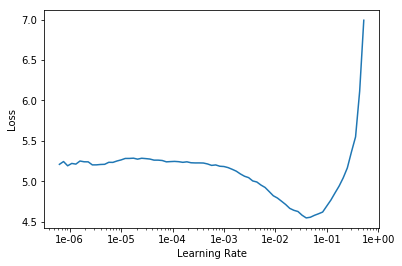

In [16]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(25, max_lr = 1e-2)

### Predictions

In [ ]:
preds,_ = learn.TTA(ds_type = DatasetType.Test)

preds = np.argmax(preds,1)